# ME 696 Homework 3

## Particle Filter on a Linear-Gaussian System 

In this exercise,  you are asked to design a particle filter for a simple dynamical system: a car with linear dynamics moving in a linear environment.  Assume $\Delta t=1$ for simplicity.  The position of the car at time $t$ is given by $x$.  Its velocity is $\dot{x}_t$, and its acceleration is $\ddot{x}_t$.  Suppose the acceleration is set randomly at each point in time, according to a Gaussian with zero mean and covariance $\sigma^2=1$.

(a)  What is a minimal state vector for the particle filter such that the resulting system is Markovian? 

(b)  For your state vector, design the state transition probability $p(x_t|u_t,x_{t−1})$. *Hint:  This transition function will possess linear matrices $A$ and $B$ and a noise covariance $R$*.

(c) Implement the state prediction step of the particle filter in your programming language of choice.
Assuming we know at time $t = 0$, $x_0 = \dot{x}_0 = \ddot{x}_0 = 0$. Plot the state distributions for times
$t = 1,2,\dots,5$.

(d) For each value of $t$, plot the joint posterior over $x$ and $\dot{x}$ where $x$ is the horizontal axis and $\dot{x}$ is the vertical axis. For each posterior, you are asked to plot an uncertainty ellipse, which is the
ellipse of points that are one standard deviation away from the mean.

(e) What will happen to the correlation between $x_t$ and $\dot{x}_t$ as $t\rightarrow \infty$.

We will now add measurements to our particle filter. Suppose at time $t$, we can receive a noisy
observation of $x$. In expectation, our sensor measures the true location. However, this measurement is
corrupted by Gaussian noise with covariance $\sigma^2 = 10$.

(f) Define the measurement model. *Hint: You need to define a matrix $C$ and another matrix $Q$*.

(g) Implement the measurement update. Suppose at time $t = 5$, we observe a measurement $z =
5$. State the parameters of the Gaussian approximation of the particle distribution before and
after updating the particle filter. Plot the uncertainty ellipse before and after incorporating the
measurement.

---

### (a)  What is a minimal state vector for the particle filter such that the resulting system is Markovian? 

In order for the system to be Markovian, the current state should only depend on its previous state(s). Since the car has linear dynamics moving in a linear environment, we can write the dynamics as follows: 
<center>
$
    \begin{equation}
        x_{t} = x_{t-1} + \dot{x}_t \Delta t + \frac{1}{2} \ddot{x} (\Delta t)^2
    \end{equation}
$
</center> 

<center>
$
    \begin{equation}
        \dot{x}_t = \dot{x}_{t-1} + \ddot{x} \Delta t
    \end{equation}
$
</center>
The acceleration of the car essentially controls the other state variables (velocity and position). Therefore, the acceleration term is the control and the minimum state vector is: 
<center>
    \begin{equation}
        \mathbf{x}_t = \begin{bmatrix} x_{t} \\ \dot{x}_{t} \end{bmatrix}
    \end{equation}
</center>

---

### (b)  For your state vector, design the state transition probability $p(x_t|u_t,x_{t−1})$. *Hint:  This transition function will possess linear matrices $A$ and $B$ and a noise covariance $R$*.

The state transition function has the form $\mathbf{x}_t = A\mathbf{x}_{t-1} + B\mathbf{u}_{t-1} + w_{t-1}$ where, 

<center>
    $A \triangleq \begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}$, <br> <br>
    $B \triangleq \begin{bmatrix} \frac{1}{2} (\Delta t)^2 \\ \Delta t \end{bmatrix}$, <br> <br>
    $\mathbf{x}_t \triangleq \begin{bmatrix} x_t \\ \dot{x}_t \end{bmatrix}$, and<br> <br>
    $\mathbf{u}_t \triangleq \ddot{x}_t \sim \mathcal{N}(0, \sigma^2)$ <br> <br>
</center>

Since $\Delta t = 1$, 
<center>
    $A = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}$, <br> <br>
    $B = \begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}$
</center>

The error noise is a function of the acceleration term since the acceleration is modeled by a zero-mean Gaussian with covariance $\sigma^2$. With the definitions defined above, the full state transition function is: 

<center>
    $
    \mathbf{x}_t = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}\mathbf{x}_{t-1} + 
    \begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}\ddot{x}_{t-1} + 
    \underbrace{\begin{bmatrix} \frac{1}{2} \\ 1 \end{bmatrix}\sigma^2}_{R}
    $
</center>

The state-transistion probability is: 

<center>
    $
    p(\mathbf{x}_t|\mathbf{u}_t,\mathbf{x}_{t−1}) = 
    \frac{1}{\sqrt{2\pi |R|}}exp\{-\frac{1}{2}(\mathbf{x}-\mathbf{x}_{t-1})^T R^{-1}(\mathbf{x}-\mathbf{x}_{t-1})\}
    $
</center>

---

### (c) Implement the state prediction step of the particle filter in your programming language of choice. Assuming we know at time $t = 0$, $x_0 = \dot{x}_0 = \ddot{x}_0 = 0$. Plot the state distributions for times $t = 1,2,\dots,5$.


In [92]:
# Import libraries
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt

In [93]:
# Functions
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
        
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into. 
        
    n_std : float
        The number of standard deviations to determine the ellipse's raiuses.
        
    **kwargs
        Forwarded to `-matplotlib.patches.Ellipse`
    
    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
        
    cov = np.cov(x,y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                          facecolor=facecolor, **kwargs)
    
    # Calculating the standard deviation of x from 
    # the squareroot of the variance and multiplying 
    # with the given number of standard deviations. 
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    
    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def multivariate_gaussian(S, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    
    n = mu.shape[0]
    Sigma_det=np.linalg.det(Sigma)
    Sigma_inv=np.linalg.inv(Sigma)
    N=np.sqrt((2*np.pi)**n*Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac=np.einsum('...k,kl,...l->...',S-mu,Sigma_inv,S-mu)
    
    return np.exp(-fac/2)/N

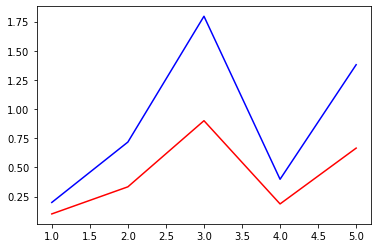

In [94]:
# Initial conditions
pos = 0
vel = 0
accel = 0

# Instantiate state matrix, control matrix, and state vector
A = np.array([[1., 1.], [0., 1.]])
B = np.array([1/2., 1.])
mu = np.array([pos, vel])
R = np.array([[1/4., 1/2.], [1/2., 1.001]])

# Calculate the state distributions for time t
t = np.linspace(1, 5, 5)
x, x_dot = np.random.multivariate_normal(mu, R, 5).T

fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.plot(t, x, color='r')
ax1.plot(t, x_dot, color='b')